In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 339 (delta 96), reused 80 (delta 62), pack-reused 171
Receiving objects: 100% (339/339), 55.24 MiB | 40.52 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=25374 sha256=2ce7feb7134fe81a7d683112552146149fd264a48933ce5de0a699395b64155b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xnps61j/wheels/55/59/29/0fb1c63565215

In [2]:
from dul_2021.utils.hw10_utils import *

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [3]:
import torch
import numpy as np
from torchvision.transforms import ToPILImage
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

In [4]:
class Cutout:
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        
        h = img.size(1)
        w = img.size(2)

        mask = np.zeros((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 1.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)

        return mask

In [102]:
class Discriminator(nn.Module):
    def __init__(self, hd=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU(),
            View((-1, 4 * 4 * 128)),
            nn.Linear(4 * 4 * 128, hd), 
            nn.ReLU(),
            nn.Linear(hd, hd), 
            nn.ReLU(),
            nn.Linear(hd, 1), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)


class ContextEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.netD = Discriminator()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            View((-1, 4 * 4 * 128)),
            nn.Linear(4 * 4 * 128, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128), 
            nn.ReLU(),
            View((-1, 128, 4, 4)),
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Tanh()
        )

        self.optD = Adam(self.netD.parameters())
        self.optEnc = Adam(self.encoder.parameters())
        self.optDec = Adam(self.decoder.parameters())

    def optimizeD(self, x, mask):
        self.optD.zero_grad()
        
        fake = self.decoder(self.encoder((1 - mask) * x)).detach()
        loss_adv = -(self.netD(x + 1e-8).log() + (1 - self.netD(fake) + 1e-8).log()).mean()
        loss_adv.backward()

        self.optD.step()

        return loss_adv.item()

    def optimize_enc_dec(self, x, mask):
        self.optEnc.zero_grad()
        self.optDec.zero_grad()

        fake = self.decoder(self.encoder((1 - mask) * x))
        loss_rec = F.mse_loss(fake, x, reduction='none') * mask

        loss_adv = self.netD(fake + 1e-8).log().mean()

        loss = loss_rec.mean() + loss_adv
        
        loss.backward()
        self.optEnc.step()
        self.optDec.step()

        return loss_rec.mean().item()
    


In [103]:
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.cutout = Cutout(1, 14)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx][0]
        mask = self.cutout(img)
        return img, mask


def train(model, dataset, batch_size=128, epochs=10):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    mse_losses = []
    adv_losses = []

    for epoch in tqdm(range(epochs)):
        for i, (x, mask) in enumerate(iter(dataloader)):
            x = x.to(device)
            mask = mask.to(device)
            loss = model.optimize_enc_dec(x, mask)
            mse_losses.append(loss)

            if i % 10 == 0:
                loss = model.optimizeD(x, mask)
                adv_losses.extend([loss] * 10)

    return model, mse_losses, adv_losses

device = 'cuda'

In [104]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    
    train_ds = CustomDataset(train_data)
    model = ContextEncoder().to(device)
    
    model, mse_losses, adv_losses = train(model, train_ds, epochs=1)

    model.eval()

    test_ds = CustomDataset(test_data)
    test_loader = DataLoader(test_ds, batch_size=10)
    images, masks = next(iter(test_loader))
    
    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)
        inp = (1 - masks) * images
        out = model.decoder(model.encoder(inp)).add(1).div(2).detach().cpu().numpy()
        sample = np.concatenate([inp.detach().cpu().numpy(), out, images.detach().cpu().numpy()], axis=0)
    return mse_losses, adv_losses, sample


  0%|          | 0/1 [00:00<?, ?it/s]

1.3884646892547607
1.3867995738983154
1.383218765258789
1.3742201328277588
1.3541110754013062
1.306915521621704
1.2230503559112549
1.0740821361541748
0.8723499774932861
0.7405292987823486
0.6822566390037537
0.6509519815444946
0.631643533706665
0.6042670011520386
0.5557259917259216
0.51328045129776
0.4375474154949188
0.3134006857872009
0.14923802018165588
0.029153091832995415
0.004991818219423294
0.00023420195793733
2.98023678624304e-06
2.2247743345360504e-06
0.06089907884597778
-0.0
0.00016547618724871427
6.142754554748535
1.6298315586027456e-07
0.3619089722633362
4.055025100708008
2.296724796295166
0.6924138069152832
0.015764212235808372
0.0003758424718398601
-0.0
-0.0
-0.0
5.960464477539063e-08
0.007602009456604719
3.371877431869507
-0.0
-0.0
0.014232837595045567
2.7939681679356454e-09
0.35382670164108276
1.659580945968628


100%|██████████| 1/1 [00:27<00:00, 27.36s/it]


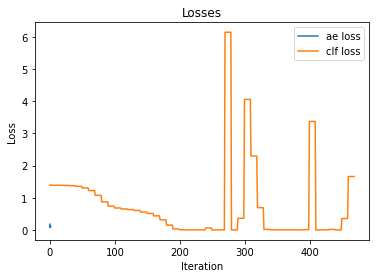

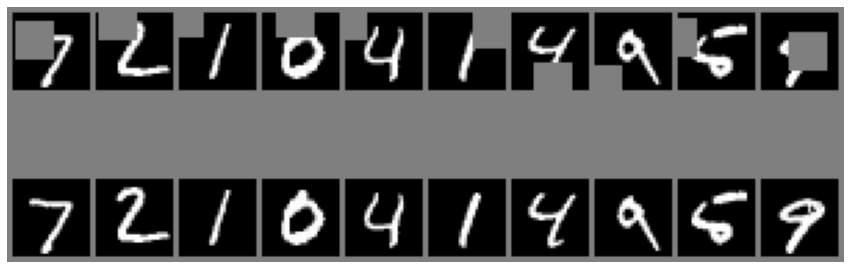

In [105]:
q1_results(q1)

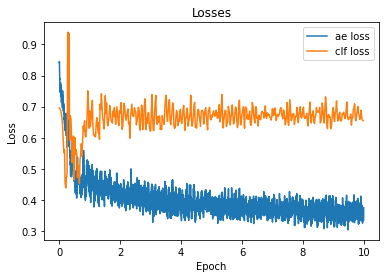

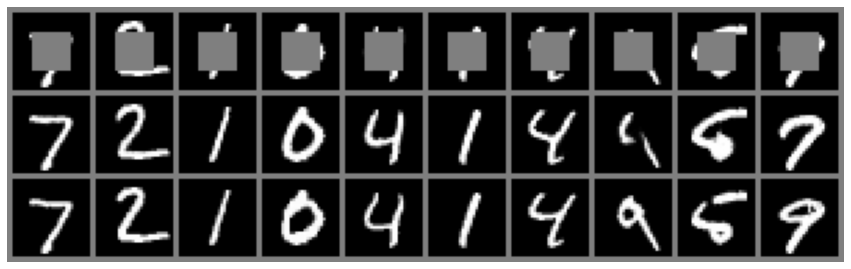

In [ ]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [109]:
from torchvision.transforms.functional import rotate
import random

In [107]:
class Classifier(nn.Module):
    def __init__(self, num_classes=4, hd=128):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU(),
            View((-1, 4 * 4 * 128)),
            nn.Linear(4 * 4 * 128, hd), 
            nn.ReLU(),
            nn.Linear(hd, hd), 
            nn.ReLU(),
            nn.Linear(hd, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [128]:
class CustomDataset(Dataset):
    def __init__(self, data, rotations=[0, 90, 180, 270]):
        self.rotations = rotations
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx][0]
        label = random.randint(0, len(self.rotations) - 1)
        img = rotate(img, self.rotations[label])
        return img, label


def train(model, dataset, epochs=10, bs=128):
    train_dl = DataLoader(dataset, shuffle=True, batch_size=bs)
    opt = Adam(model.parameters())

    losses = []
    acc = []

    for epoch in tqdm(range(epochs)):
        cur_acc = 0
        n = 0
        for (x, label) in iter(train_dl):
            x = x.to(device)
            label = label.long().to(device)
            
            out = model(x)
            loss = F.cross_entropy(out, label)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
            y_pred = torch.argmax(out, dim=-1)
            cur_acc += (label == y_pred).sum().item()
            n += x.shape[0]
        
        acc.append(cur_acc / n)

    return np.array(losses), np.array(acc)


In [129]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """

    model = Classifier()
    model.to(device)
    dataset = CustomDataset(train_data)
    losses, acc = train(model, dataset)

    return losses, acc

100%|██████████| 10/10 [03:59<00:00, 23.92s/it]


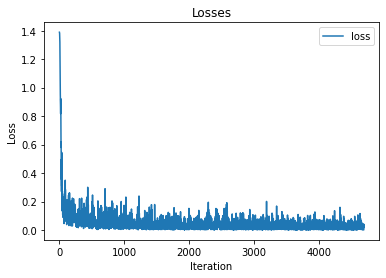

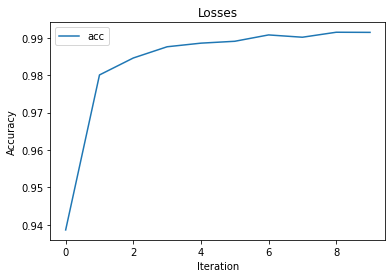

In [130]:
q2_results(q2)